In [1]:
# 📦 Librerie
import pandas as pd
import numpy as np

# 📥 Caricamento del dataset
df = pd.read_parquet("../data/processed/RM_Dimessi_clean.parquet")

# 🔍 Esplora la variabile target
print("📊 Statistiche degenza:")
print(df["degenza"].describe())

# 🧹 Rimuovi outlier (se > 180 giorni)
df = df[df["degenza"] < 180]

📊 Statistiche degenza:
count    21136.000000
mean        30.074754
std         18.939034
min          0.000000
25%         21.000000
50%         29.000000
75%         39.000000
max       1340.000000
Name: degenza, dtype: float64


In [3]:
# 📥 Dati
df = pd.read_parquet("../data/processed/RM_Dimessi_clean.parquet")

# 🔧 Variabili derivate da creare
df["barthel_totale_ingresso"] = df[[f"bartric{i}" for i in range(1, 12)]].sum(axis=1)

# 🧼 Pulizia dati già discussa
df = df[df["degenza"] < 180]  # Limita outlier
df = df.dropna(subset=["degenza"])

# 👤 Età clinica
df["età_clinica"] = df["età del paziente dimesso"].apply(
    lambda x: "adulto" if x < 65 else "anziano" if x < 80 else "grande_anziano"
)

In [5]:
# 🎯 Variabili predittive all’ingresso
feature_cols = [
    "età del paziente dimesso", "sesso", "età_clinica",
    "barthel_totale_ingresso",
    "totale_drsric", "gosric", "lcfric", "totale_scimric",
    "locomric", "respirric", "contrsfinric", "nutrric", "trachric",
    "postcomric", "mieloric", "ASIAric", "tipdim",
    "intproc1", "intproc2", "intproc3", "intproc4", "intproc5",
    "intproc6", "intproc7", "intproc8", "intproc9", "intproc10"
]

X_raw = df[feature_cols].copy()
y = df["degenza"].copy()

# 👀 Nulli
print(X_raw.isnull().sum().sort_values(ascending=False).head(10))

totale_drsric     21125
gosric            21125
lcfric            21125
ASIAric           21125
totale_scimric    21117
intproc10         16336
intproc9          13896
intproc8          11592
intproc7           9655
intproc6           7827
dtype: int64


In [6]:
# 🧼 Elimina colonne con più del 95% di NaN
thresh = len(X_raw) * 0.05
X_raw = X_raw.dropna(axis=1, thresh=thresh)

In [7]:
from sklearn.impute import SimpleImputer

# 🔍 Riclassifica variabili numeriche e categoriche
num_cols = X_raw.select_dtypes(include=["number"]).columns
cat_cols = X_raw.select_dtypes(include=["object", "category", "bool"]).columns

# 🧽 Imputazione
X_num = pd.DataFrame(SimpleImputer(strategy="median").fit_transform(X_raw[num_cols]), columns=num_cols)
X_cat = pd.DataFrame(SimpleImputer(strategy="constant", fill_value="missing").fit_transform(X_raw[cat_cols]), columns=cat_cols)

# 🔁 Encoding categorico
X = pd.get_dummies(pd.concat([X_num, X_cat], axis=1), drop_first=True)

In [8]:
X.shape

(21125, 22)

In [13]:
# 📦 Librerie
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, r2_score

# 📥 Dataset
df = pd.read_parquet("../data/processed/RM_Dimessi_clean.parquet")

# 📊 Statistiche
print("📊 Statistiche degenza:")
print(df["degenza"].describe())

# 🎯 Colonne da usare
feature_cols = [
    "età del paziente dimesso", "sesso",
    "totale_drsric", "gosric", "lcfric", "ASIAric", "totale_scimric",
    "intproc1", "intproc2", "intproc3", "intproc4", "intproc5",
    "intproc6", "intproc7", "intproc8", "intproc9", "intproc10"
]

# 🔧 Feature grezze
X_raw = df[feature_cols].copy()
y = df["degenza"].copy()

# 🔍 Controllo NaN per debug
print("🔍 Valori non nulli per colonna:")
print(X_raw.isnull().sum())

# 🔧 Separazione colonne numeriche e categoriche
num_cols = X_raw.select_dtypes(include=["number"]).columns
cat_cols = X_raw.select_dtypes(include=["object", "category", "bool"]).columns

# 🔧 Rimuove colonne numeriche completamente vuote
num_cols_valid = X_raw[num_cols].dropna(axis=1, how='all').columns

# 🧼 Imputazione numeriche
X_num = pd.DataFrame(
    SimpleImputer(strategy="median").fit_transform(X_raw[num_cols_valid]),
    columns=num_cols_valid,
    index=X_raw.index
)

# 🧼 Imputazione categoriche
if len(cat_cols) > 0:
    X_cat = pd.DataFrame(
        SimpleImputer(strategy="constant", fill_value="missing").fit_transform(X_raw[cat_cols]),
        columns=cat_cols,
        index=X_raw.index
    )
else:
    X_cat = pd.DataFrame(index=X_raw.index)

# 🧱 Unione e encoding
X = pd.get_dummies(pd.concat([X_num, X_cat], axis=1), drop_first=True)

# 🧹 Pulizia: rimuove righe con target non valido
mask_valid = y.notna() & np.isfinite(y) & (y < 1e6)
X = X.loc[mask_valid]
y = y.loc[mask_valid]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = XGBRegressor(n_estimators=300, max_depth=6, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# 📈 Valutazione
y_pred = model.predict(X_test)
print(f"🎯 MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"📈 R²: {r2_score(y_test, y_pred):.3f}")

📊 Statistiche degenza:
count    21136.000000
mean        30.074754
std         18.939034
min          0.000000
25%         21.000000
50%         29.000000
75%         39.000000
max       1340.000000
Name: degenza, dtype: float64
🔍 Valori non nulli per colonna:
età del paziente dimesso        5
sesso                           1
totale_drsric               21141
gosric                      21141
lcfric                      21141
ASIAric                     21141
totale_scimric              21133
intproc1                      141
intproc2                      200
intproc3                      255
intproc4                     2614
intproc5                     5487
intproc6                     7833
intproc7                     9662
intproc8                    11600
intproc9                    13905
intproc10                   16347
dtype: int64
🎯 MAE: 9.87
📈 R²: 0.046


## Performance troppo basse, dobbiamo ricalibrare il tutto (features + ottimizzazione del modello)

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor

# 📥 Dataset
df = pd.read_parquet("../data/processed/RM_Dimessi_clean.parquet")

# 🎯 Target robusto
df["degenza"] = pd.to_numeric(df["degenza"], errors="coerce")
df = df[df["degenza"].notna() & (df["degenza"] > 0)]
df = df[df["degenza"] <= df["degenza"].quantile(0.90)]

# ➕ Barthel ingresso e classe età
df["barthel_totale_ingresso"] = df[[f"bartric{i}" for i in range(1, 12)]].sum(axis=1)
df["età_clinica"] = df["età del paziente dimesso"].apply(
    lambda x: "adulto" if x < 65 else "anziano" if x < 80 else "grande_anziano"
)

# 🔧 Feature set potenziato
feature_cols = [
    "età del paziente dimesso", "sesso", "età_clinica", "tipdim",
    "barthel_totale_ingresso", "totale_drsric", "gosric", "lcfric",
    "totale_scimric", "ASIAric",
    "intproc1", "intproc2", "intproc3", "intproc4", "intproc5",
    "intproc6", "intproc7", "intproc8", "intproc9", "intproc10"
]

X_raw = df[feature_cols].copy()
y = df["degenza"].copy()

# 🧼 Imputazione
num_cols = X_raw.select_dtypes(include=["number"]).columns
cat_cols = X_raw.select_dtypes(include=["object", "category", "bool"]).columns
num_cols_valid = [col for col in num_cols if X_raw[col].notna().sum() > 0]

X_num = pd.DataFrame(
    SimpleImputer(strategy="median").fit_transform(X_raw[num_cols_valid]),
    columns=num_cols_valid,
    index=X_raw.index
)

if len(cat_cols) > 0:
    X_cat = pd.DataFrame(
        SimpleImputer(strategy="constant", fill_value="missing").fit_transform(X_raw[cat_cols]),
        columns=cat_cols,
        index=X_raw.index
    )
else:
    X_cat = pd.DataFrame(index=X_raw.index)

X = pd.get_dummies(pd.concat([X_num, X_cat], axis=1), drop_first=True)

# 🔀 Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y.loc[X.index], test_size=0.2, random_state=42)

# 🚀 Modellazione XGBoost
model = XGBRegressor(n_estimators=300, max_depth=6, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# 📈 Metriche
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("🎯 MAE:", round(mae, 2))
print("📈 R²:", round(r2, 3))

🎯 MAE: 6.52
📈 R²: 0.42


In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor

# 📥 Dataset
df = pd.read_parquet("../data/processed/RM_Dimessi_clean.parquet")

# 🎯 Target robusto
df["degenza"] = pd.to_numeric(df["degenza"], errors="coerce")
df = df[df["degenza"].notna() & (df["degenza"] > 0)]
df = df[df["degenza"] <= df["degenza"].quantile(0.90)]

# ➕ Barthel ingresso e classe età
df["barthel_totale_ingresso"] = df[[f"bartric{i}" for i in range(1, 12)]].sum(axis=1)
df["età_clinica"] = df["età del paziente dimesso"].apply(
    lambda x: "adulto" if x < 65 else "anziano" if x < 80 else "grande_anziano"
)

# 🔧 Feature set potenziato
feature_cols = [
    "età del paziente dimesso", "sesso", "età_clinica", "tipdim",
    "barthel_totale_ingresso", "totale_drsric", "gosric", "lcfric",
    "totale_scimric", "ASIAric",
    "intproc1", "intproc2", "intproc3", "intproc4", "intproc5",
    "intproc6", "intproc7", "intproc8", "intproc9", "intproc10"
]

X_raw = df[feature_cols].copy()
y = df["degenza"].copy()

# 🧼 Imputazione
num_cols = X_raw.select_dtypes(include=["number"]).columns
cat_cols = X_raw.select_dtypes(include=["object", "category", "bool"]).columns
num_cols_valid = [col for col in num_cols if X_raw[col].notna().sum() > 0]

X_num = pd.DataFrame(
    SimpleImputer(strategy="median").fit_transform(X_raw[num_cols_valid]),
    columns=num_cols_valid,
    index=X_raw.index
)

if len(cat_cols) > 0:
    X_cat = pd.DataFrame(
        SimpleImputer(strategy="constant", fill_value="missing").fit_transform(X_raw[cat_cols]),
        columns=cat_cols,
        index=X_raw.index
    )
else:
    X_cat = pd.DataFrame(index=X_raw.index)

X = pd.get_dummies(pd.concat([X_num, X_cat], axis=1), drop_first=True)

# 🔀 Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y.loc[X.index], test_size=0.2, random_state=42)

# 🔍 GridSearchCV su XGBRegressor
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [2, 4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0]
}

xgb = XGBRegressor(random_state=42)
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='r2',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# 📈 Metriche finali
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("🎯 MAE:", round(mae, 2))
print("📈 R²:", round(r2, 3))
print("✅ Best params:", grid_search.best_params_)

Fitting 3 folds for each of 60 candidates, totalling 180 fits
🎯 MAE: 6.52
📈 R²: 0.424
✅ Best params: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.8}


# Proviamo Optuna Optimization

In [19]:
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from xgboost import XGBRegressor

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 1000, step=100),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 5),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 5),
        "random_state": 42,
        "n_jobs": -1,
    }

    model = XGBRegressor(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return r2_score(y_test, preds)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, timeout=600)

# 🚀 Best Model
print("✅ Best R²:", study.best_value)
print("✅ Best params:", study.best_params)

# Refit con i migliori parametri
best_model = XGBRegressor(**study.best_params)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("🎯 MAE:", round(mae, 2))
print("📈 R²:", round(r2, 3))

[I 2025-06-10 11:36:03,622] A new study created in memory with name: no-name-153bb378-6923-44be-bb1c-302245a32b66
[I 2025-06-10 11:36:04,219] Trial 0 finished with value: 0.41739236820793524 and parameters: {'n_estimators': 800, 'max_depth': 3, 'learning_rate': 0.160153120204043, 'subsample': 0.944205880749027, 'colsample_bytree': 0.5259470106916213, 'gamma': 0.9245031003603815, 'reg_alpha': 4.493351858265829, 'reg_lambda': 4.132148671829709}. Best is trial 0 with value: 0.41739236820793524.
[I 2025-06-10 11:36:04,605] Trial 1 finished with value: 0.3851273314951661 and parameters: {'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.2755223586919946, 'subsample': 0.8516716815637766, 'colsample_bytree': 0.8909753180471086, 'gamma': 3.958859693883134, 'reg_alpha': 1.2884508686542802, 'reg_lambda': 1.680750021353613}. Best is trial 0 with value: 0.41739236820793524.
[I 2025-06-10 11:36:04,859] Trial 2 finished with value: 0.423051078382897 and parameters: {'n_estimators': 200, 'max_d

✅ Best R²: 0.43472776207568764
✅ Best params: {'n_estimators': 900, 'max_depth': 8, 'learning_rate': 0.01252946174409256, 'subsample': 0.7061409250541807, 'colsample_bytree': 0.7379935327214739, 'gamma': 1.8728701883568375, 'reg_alpha': 0.7321028796001134, 'reg_lambda': 3.1602548421506906}
🎯 MAE: 6.46
📈 R²: 0.434


# Testiamo con feature engineering

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor

# 📥 Carica dati
df = pd.read_parquet("../data/processed/RM_Dimessi_clean.parquet")

# 🎯 Preprocessing degenza
df["degenza"] = pd.to_numeric(df["degenza"], errors="coerce")
df = df[df["degenza"].notna() & (df["degenza"] > 0)]
df = df[df["degenza"] <= df["degenza"].quantile(0.90)]

# ➕ Barthel ingresso e classe età
df["barthel_totale_ingresso"] = df[[f"bartric{i}" for i in range(1, 12)]].sum(axis=1)
df["età_clinica"] = df["età del paziente dimesso"].apply(
    lambda x: "adulto" if x < 65 else "anziano" if x < 80 else "grande_anziano"
)

# 🧠 Feature engineering - Step 1 e 2
df["indice_complessità_clinica"] = df[["totale_drsric", "gosric", "lcfric", "ASIAric", "totale_scimric"]].sum(axis=1)

proc_cols = [f"intproc{i}" for i in range(1, 11)]
df["numero_procedure"] = df[proc_cols].notna().sum(axis=1)

# 🏗️ Feature set completo + ingegnerizzato
feature_cols = [
    "età del paziente dimesso", "sesso", "età_clinica", "tipdim",
    "barthel_totale_ingresso",
    "totale_drsric", "gosric", "lcfric", "ASIAric", "totale_scimric",
    "indice_complessità_clinica", "numero_procedure"
] + [f"intproc{i}" for i in range(1, 11)]


X_raw = df[feature_cols].copy()
y = df["degenza"].copy()

# 🧼 Imputazione
num_cols = X_raw.select_dtypes(include=["number"]).columns
cat_cols = X_raw.select_dtypes(include=["object", "category", "bool"]).columns
num_cols_valid = [col for col in num_cols if X_raw[col].notna().sum() > 0]

X_num = pd.DataFrame(
    SimpleImputer(strategy="median").fit_transform(X_raw[num_cols_valid]),
    columns=num_cols_valid,
    index=X_raw.index
)

if len(cat_cols) > 0:
    X_cat = pd.DataFrame(
        SimpleImputer(strategy="constant", fill_value="missing").fit_transform(X_raw[cat_cols]),
        columns=cat_cols,
        index=X_raw.index
    )
else:
    X_cat = pd.DataFrame(index=X_raw.index)

X = pd.get_dummies(pd.concat([X_num, X_cat], axis=1), drop_first=True)

# 🔀 Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y.loc[X.index], test_size=0.2, random_state=42)

# 🚀 XGBoost con iperparametri da Optuna
model = XGBRegressor(
    n_estimators=900,
    max_depth=8,
    learning_rate=0.01252946174409256,
    subsample=0.7061409250541807,
    colsample_bytree=0.7379935327214739,
    gamma=1.8728701883568375,
    reg_alpha=0.7321028796001134,
    reg_lambda=3.1602548421506906,
    random_state=42
)

# 🏋️ Training
model.fit(X_train, y_train)

# 📈 Valutazione
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("🎯 MAE:", round(mae, 2))
print("📈 R²:", round(r2, 3))

🎯 MAE: 6.43
📈 R²: 0.439


# Siamo a Plateau, facciamo classificazione a fasce di degenza.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier

# 📥 Carica dataset
df = pd.read_parquet("../data/processed/RM_Dimessi_clean.parquet")

# 🎯 Target pulito
df["degenza"] = pd.to_numeric(df["degenza"], errors="coerce")
df = df[df["degenza"].notna() & (df["degenza"] > 0)]
df = df[df["degenza"] <= df["degenza"].quantile(0.90)]  # Rimuoviamo outlier oltre P90

# ➕ Feature aggiuntive
df["barthel_totale_ingresso"] = df[[f"bartric{i}" for i in range(1, 12)]].sum(axis=1)
df["età_clinica"] = df["età del paziente dimesso"].apply(
    lambda x: "adulto" if x < 65 else "anziano" if x < 80 else "grande_anziano"
)

# 🔢 Trasformiamo la degenza in classi
df["degenza_classe"] = pd.cut(
    df["degenza"],
    bins=[0, 15, 30, 45, 60, np.inf],
    labels=["<15", "15–30", "30–45", "45–60", "60+"]
)

# 🎯 Nuovo target
y = df["degenza_classe"].astype(str)

# 📊 Feature set
feature_cols = [
    "età del paziente dimesso", "sesso", "età_clinica", "tipdim",
    "barthel_totale_ingresso", "totale_drsric", "gosric", "lcfric",
    "totale_scimric", "ASIAric",
    "intproc1", "intproc2", "intproc3", "intproc4", "intproc5",
    "intproc6", "intproc7", "intproc8", "intproc9", "intproc10"
]
X_raw = df[feature_cols].copy()

# 🧼 Imputazione
num_cols = X_raw.select_dtypes(include=["number"]).columns
cat_cols = X_raw.select_dtypes(include=["object", "category", "bool"]).columns
num_cols_valid = [col for col in num_cols if X_raw[col].notna().sum() > 0]

X_num = pd.DataFrame(
    SimpleImputer(strategy="median").fit_transform(X_raw[num_cols_valid]),
    columns=num_cols_valid,
    index=X_raw.index
)

if len(cat_cols) > 0:
    X_cat = pd.DataFrame(
        SimpleImputer(strategy="constant", fill_value="missing").fit_transform(X_raw[cat_cols]),
        columns=cat_cols,
        index=X_raw.index
    )
else:
    X_cat = pd.DataFrame(index=X_raw.index)

X = pd.get_dummies(pd.concat([X_num, X_cat], axis=1), drop_first=True)

from sklearn.preprocessing import LabelEncoder

# 🔁 Encoding delle classi in interi
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 🔀 Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# 🚀 Classificatore XGBoost
clf = XGBClassifier(
    n_estimators=900,
    max_depth=8,
    learning_rate=0.0125,
    subsample=0.7061,
    colsample_bytree=0.738,
    gamma=1.873,
    reg_alpha=0.732,
    reg_lambda=3.16,
    random_state=42,
    use_label_encoder=False,
    eval_metric="mlogloss"
)

clf.fit(X_train, y_train)

# 📈 Valutazione
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("✅ Accuracy:", round(acc, 3))
print("📋 Classification Report:\n", report)

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2 3], got ['15–30' '30–45' '45–60' '<15']

In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

# 📥 Caricamento dati
df = pd.read_parquet("../data/processed/RM_Dimessi_clean.parquet")

# 🎯 Target: degenza pulita
df["degenza"] = pd.to_numeric(df["degenza"], errors="coerce")
df = df[df["degenza"].notna() & (df["degenza"] > 0)]
df = df[df["degenza"] <= df["degenza"].quantile(0.90)]

# ➕ Feature derivate
df["barthel_totale_ingresso"] = df[[f"bartric{i}" for i in range(1, 12)]].sum(axis=1)
df["età_clinica"] = df["età del paziente dimesso"].apply(
    lambda x: "adulto" if x < 65 else "anziano" if x < 80 else "grande_anziano"
)

# 🪜 Classi di degenza
def classify_degenza(d):
    if d < 15:
        return "<15"
    elif d < 30:
        return "15–30"
    elif d < 45:
        return "30–45"
    else:
        return "45–60"

df["degenza_class"] = df["degenza"].apply(classify_degenza)

# 🔧 Feature set
feature_cols = [
    "età del paziente dimesso", "sesso", "età_clinica", "tipdim",
    "barthel_totale_ingresso", "totale_drsric", "gosric", "lcfric",
    "totale_scimric", "ASIAric",
    "intproc1", "intproc2", "intproc3", "intproc4", "intproc5",
    "intproc6", "intproc7", "intproc8", "intproc9", "intproc10"
]

X_raw = df[feature_cols].copy()
y = df["degenza_class"].copy()

# 🧼 Imputazione
num_cols = X_raw.select_dtypes(include=["number"]).columns
cat_cols = X_raw.select_dtypes(include=["object", "category", "bool"]).columns
num_cols_valid = [col for col in num_cols if X_raw[col].notna().sum() > 0]

X_num = pd.DataFrame(
    SimpleImputer(strategy="median").fit_transform(X_raw[num_cols_valid]),
    columns=num_cols_valid,
    index=X_raw.index
)

if len(cat_cols) > 0:
    X_cat = pd.DataFrame(
        SimpleImputer(strategy="constant", fill_value="missing").fit_transform(X_raw[cat_cols]),
        columns=cat_cols,
        index=X_raw.index
    )
else:
    X_cat = pd.DataFrame(index=X_raw.index)

X = pd.get_dummies(pd.concat([X_num, X_cat], axis=1), drop_first=True)

# 🔁 Encoding classi target
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 🔀 Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# 🚀 Classificatore XGBoost con best params da Optuna
clf = XGBClassifier(
    n_estimators=900,
    max_depth=8,
    learning_rate=0.01252946174409256,
    subsample=0.7061409250541807,
    colsample_bytree=0.7379935327214739,
    gamma=1.8728701883568375,
    reg_alpha=0.7321028796001134,
    reg_lambda=3.1602548421506906,
    use_label_encoder=False,
    eval_metric="mlogloss",
    random_state=42
)

clf.fit(X_train, y_train)

# 📈 Valutazione
y_pred = clf.predict(X_test)

print("✅ Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("📋 Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

/Users/dantetrabassi/Desktop/rehab-intelligence/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [11:59:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Accuracy: 0.602
📋 Classification Report:
               precision    recall  f1-score   support

       15–30       0.59      0.64      0.61      1622
       30–45       0.63      0.68      0.65      1501
       45–60       0.00      0.00      0.00       133
         <15       0.56      0.41      0.47       538

    accuracy                           0.60      3794
   macro avg       0.44      0.43      0.43      3794
weighted avg       0.58      0.60      0.59      3794



/Users/dantetrabassi/Desktop/rehab-intelligence/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/dantetrabassi/Desktop/rehab-intelligence/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/dantetrabassi/Desktop/rehab-intelligence/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control 

/Users/dantetrabassi/Desktop/rehab-intelligence/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:27:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Accuracy: 0.763
🎯 F1-score: 0.721
📋 Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.80      0.79      2160
           1       0.73      0.71      0.72      1634

    accuracy                           0.76      3794
   macro avg       0.76      0.76      0.76      3794
weighted avg       0.76      0.76      0.76      3794



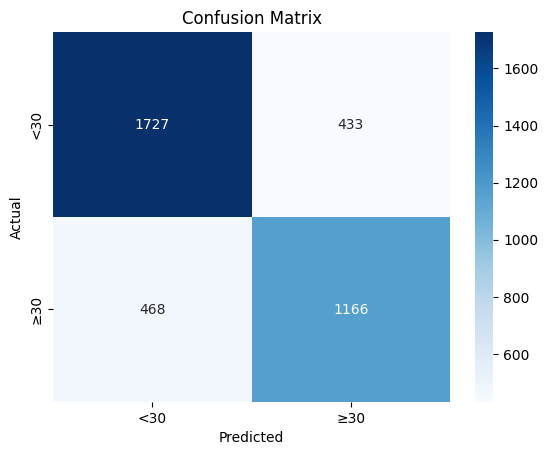

In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt

# 📥 Dataset
df = pd.read_parquet("../data/processed/RM_Dimessi_clean.parquet")

# 🎯 Target: rimuoviamo outlier e creiamo classi binarie
df["degenza"] = pd.to_numeric(df["degenza"], errors="coerce")
df = df[df["degenza"].notna() & (df["degenza"] > 0)]
df = df[df["degenza"] <= df["degenza"].quantile(0.90)]

# Nuova variabile target binaria
df["degenza_binaria"] = df["degenza"].apply(lambda x: 0 if x < 30 else 1)

# ➕ Barthel ingresso e classe età
df["barthel_totale_ingresso"] = df[[f"bartric{i}" for i in range(1, 12)]].sum(axis=1)
df["età_clinica"] = df["età del paziente dimesso"].apply(
    lambda x: "adulto" if x < 65 else "anziano" if x < 80 else "grande_anziano"
)

# 🔧 Feature set potenziato
feature_cols = [
    "età del paziente dimesso", "sesso", "età_clinica", "tipdim",
    "barthel_totale_ingresso", "totale_drsric", "gosric", "lcfric",
    "totale_scimric", "ASIAric",
    "intproc1", "intproc2", "intproc3", "intproc4", "intproc5",
    "intproc6", "intproc7", "intproc8", "intproc9", "intproc10"
]

X_raw = df[feature_cols].copy()
y = df["degenza_binaria"].copy()

# 🧼 Imputazione
num_cols = X_raw.select_dtypes(include=["number"]).columns
cat_cols = X_raw.select_dtypes(include=["object", "category", "bool"]).columns
num_cols_valid = [col for col in num_cols if X_raw[col].notna().sum() > 0]

X_num = pd.DataFrame(
    SimpleImputer(strategy="median").fit_transform(X_raw[num_cols_valid]),
    columns=num_cols_valid,
    index=X_raw.index
)

if len(cat_cols) > 0:
    X_cat = pd.DataFrame(
        SimpleImputer(strategy="constant", fill_value="missing").fit_transform(X_raw[cat_cols]),
        columns=cat_cols,
        index=X_raw.index
    )
else:
    X_cat = pd.DataFrame(index=X_raw.index)

X = pd.get_dummies(pd.concat([X_num, X_cat], axis=1), drop_first=True)

# 🧼 Forziamo X ad avere solo float64
X = pd.get_dummies(pd.concat([X_num, X_cat], axis=1), drop_first=True)
X = X.astype(np.float64)  # << Aggiungi questa riga

# 🔀 Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 🚀 XGBoost Classifier con parametri ottimizzati
clf = XGBClassifier(
    n_estimators=900,
    max_depth=8,
    learning_rate=0.01252946174409256,
    subsample=0.7061409250541807,
    colsample_bytree=0.7379935327214739,
    gamma=1.8728701883568375,
    reg_alpha=0.7321028796001134,
    reg_lambda=3.1602548421506906,
    objective="binary:logistic",
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42
)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# 📊 Metriche
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("✅ Accuracy:", round(accuracy, 3))
print("🎯 F1-score:", round(f1, 3))
print("📋 Classification Report:")
print(classification_report(y_test, y_pred))

# 🔍 Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=["<30", "≥30"], yticklabels=["<30", "≥30"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

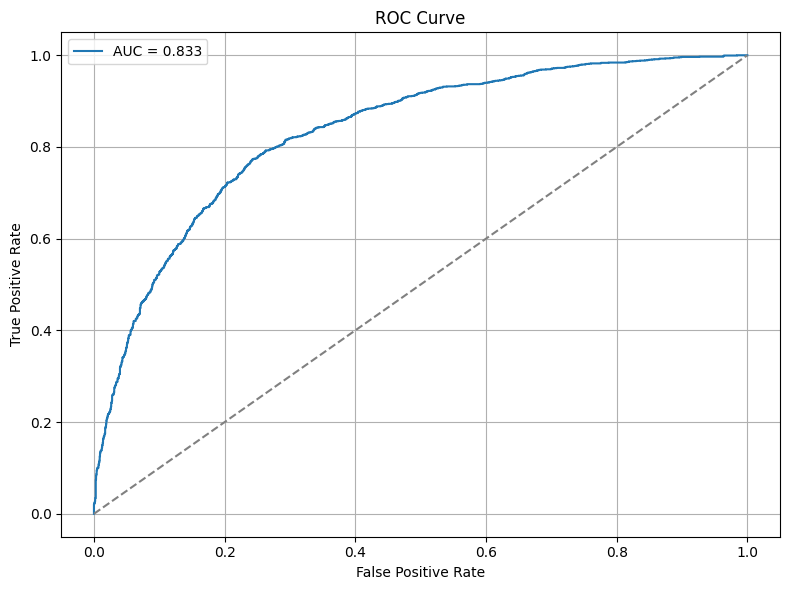

📐 AUC: 0.833


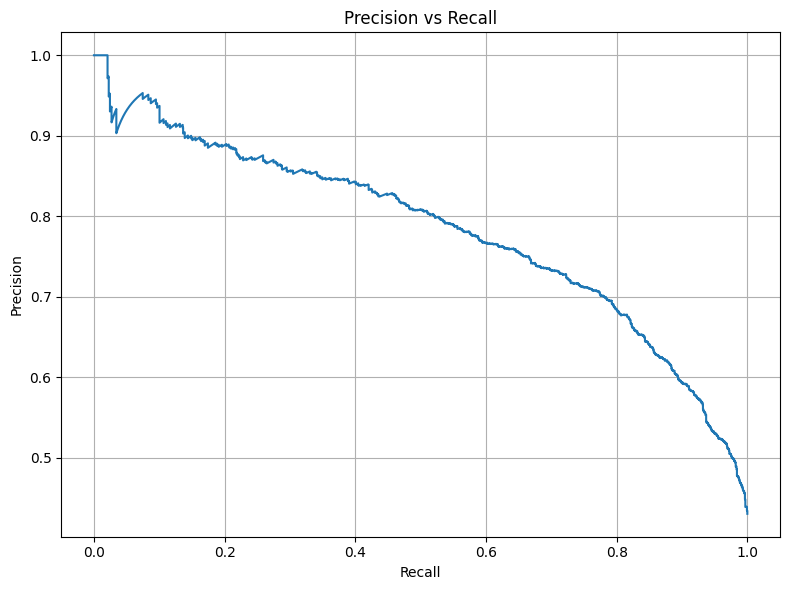

📏 Threshold=0.3 → Accuracy: 0.719, F1-score: 0.727
📏 Threshold=0.5 → Accuracy: 0.763, F1-score: 0.721
📏 Threshold=0.7 → Accuracy: 0.720, F1-score: 0.577


In [28]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve

# 🔮 Probabilità per classe positiva
y_proba = clf.predict_proba(X_test)[:, 1]

# 📈 ROC Curve e AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("📐 AUC:", round(roc_auc, 3))

# 📊 Precision-Recall Curve (utile se classi sono sbilanciate)
precision, recall, _ = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision vs Recall")
plt.grid(True)
plt.tight_layout()
plt.show()

# (Opzionale) Soglie per ottimizzazione clinica
for thr in [0.3, 0.5, 0.7]:
    pred_thr = (y_proba >= thr).astype(int)
    acc_thr = accuracy_score(y_test, pred_thr)
    f1_thr = f1_score(y_test, pred_thr)
    print(f"📏 Threshold={thr} → Accuracy: {acc_thr:.3f}, F1-score: {f1_thr:.3f}")

📊 Analisi soglie
Threshold	Accuracy	F1-score	Interpretazione
0.3	0.719	0.727	Favorisce i positivi (degenza ≥30gg). Buona scelta se vogliamo ridurre i falsi negativi.
0.5	0.763	0.721	Compromesso bilanciato, ottimo come default.
0.7	0.720	0.577	Troppo conservativo: penalizza recall sui pazienti lunghi. Poco utile in pratica.

🧠 Raccomandazione clinica
Se l’obiettivo è non sottovalutare pazienti a rischio di degenza lunga, allora threshold = 0.3 è preferibile:
✔️ maggiore sensibilità sui soggetti con degenza ≥30gg
❗ accetta più falsi positivi per non perdere casi critici

/Users/dantetrabassi/Desktop/rehab-intelligence/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:27:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
100%|===================| 18946/18969 [07:34<00:00]        

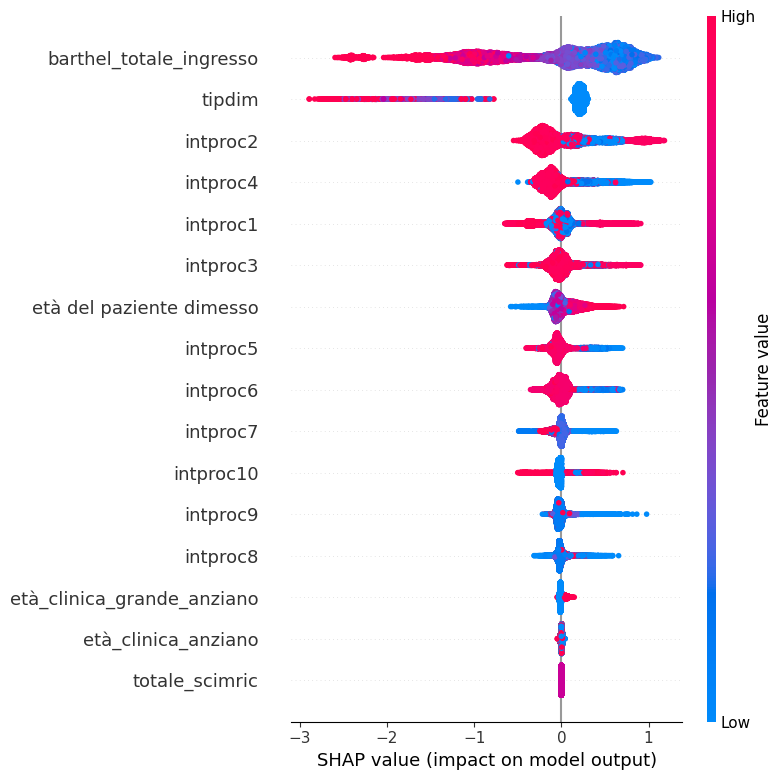

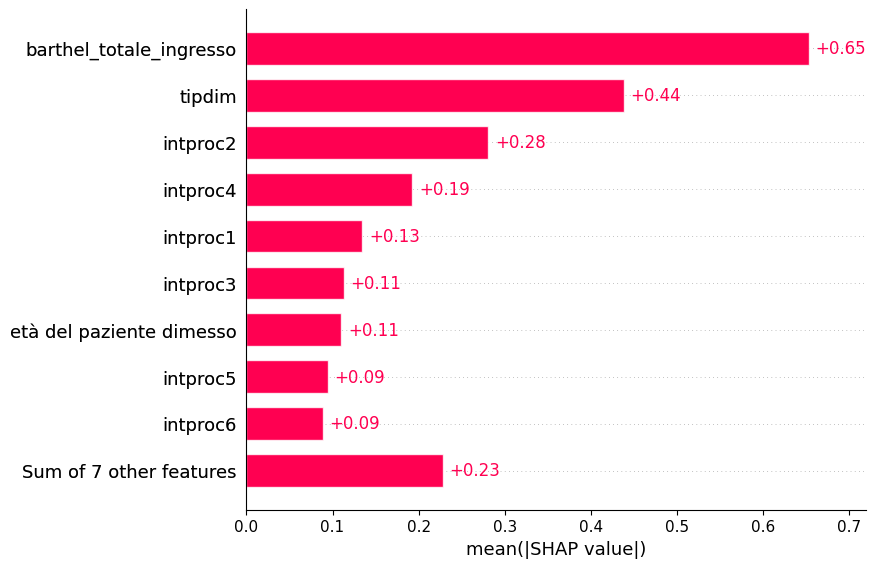

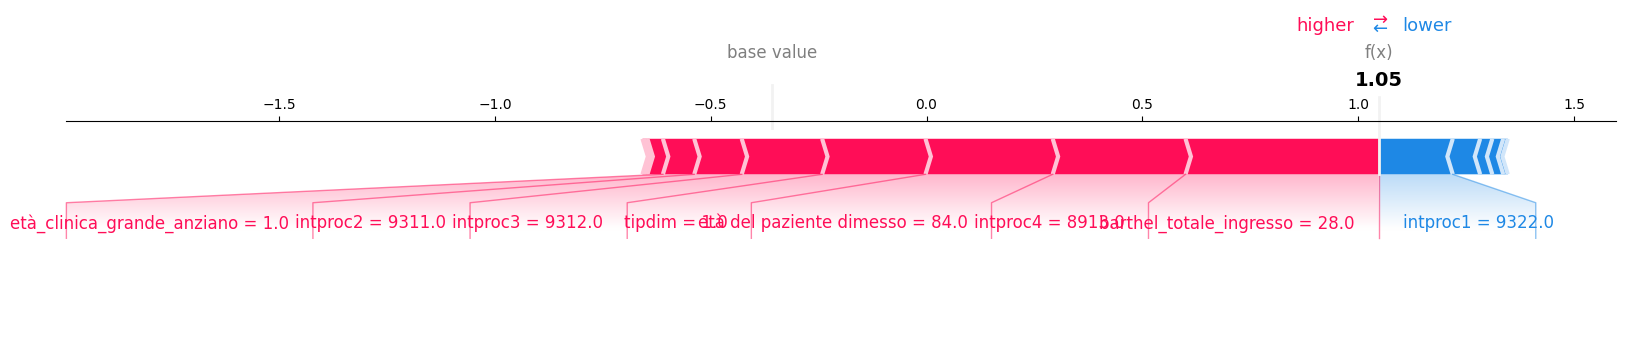

In [29]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 🔁 Refit su tutto il dataset per avere più osservazioni
clf.fit(X, y)

# 💡 Calcolo SHAP values
explainer = shap.Explainer(clf, X)
shap_values = explainer(X)

# 📊 1. Summary plot con beeswarm (importanza e direzione effetto)
plt.figure()
shap.summary_plot(shap_values, X)

# 📊 2. Bar chart delle feature più importanti
plt.figure()
shap.plots.bar(shap_values)

# 👤 3. Force plot per singolo paziente (es. primo del test set)
i = 0
shap.plots.force(shap_values[i], matplotlib=True)

🔍 1. SHAP Beeswarm Plot (shap.plots.beeswarm)
Significato: mostra come ciascuna feature impatta il modello, sia in positivo che negativo.

Osservazioni:

barthel_totale_ingresso: più basso è il punteggio in ingresso (colori blu), maggiore è l’impatto verso l’output 1 (cioè degenza ≥30).

tipdim: ha un effetto netto, ma i valori sono discreti/categorici codificati — potresti voler esplorare quale modalità corrisponde a outcome peggiori.

I codici intervento (intproc) hanno effetti rilevanti. Alcuni sono fortemente associati a degenze lunghe (rosso, SHAP alto).

📊 2. SHAP Bar Plot (mean absolute SHAP values)
Significato: importanza media delle feature.

Osservazioni:

Conferma quanto visto sopra: barthel_totale_ingresso, tipdim e intprocX sono i driver principali.

età del paziente dimesso è importante ma meno influente del Barthel.

🧬 3. SHAP Force Plot per un singolo paziente
Significato: spiega la predizione individuale come somma di forze che spingono verso una certa classe.

Osservazioni cliniche:

Il paziente è stato classificato come ad alta probabilità di degenza lunga (output = 1.05).

Le variabili che spingono verso output 1 (f(x) > 0.5) sono:

età_clinica_grande_anziano = 1.0

intproc2, intproc3, intproc4 con valori elevati (probabilmente codifiche per procedure invasive o complesse)

tipdim = altro

L’unica variabile che spinge verso una degenza più breve è:

barthel_totale_ingresso = 28.0 → un valore relativamente alto (forse vicino alla media)

✅ Conclusione operativa
Hai in mano un sistema interpretabile che:

Identifica i pazienti a rischio di degenza lunga con buona accuratezza (76%).

Permette regole cliniche del tipo:

Se barthel_totale_ingresso < 30 e età_clinica = grande_anziano e tipdim = 1, allora alta probabilità di degenza ≥30 giorni.